## PART 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 1. Simple Moving Average (SMA)
def simple_moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 2. Gaussian Weighted Moving Average
def gaussian_kernel(size, std=1):
    kernel = np.exp(-0.5 * (np.arange(-size//2, size//2 + 1) / std)**2)
    return kernel / np.sum(kernel)

def gaussian_weighted_moving_average(data, window_size=10, std=1):
    kernel = gaussian_kernel(window_size, std)
    return np.convolve(data, kernel, mode='valid')

# 3. Low-Pass Butterworth Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# 4. Exponential Moving Average (EMA)
def exponential_moving_average(data, alpha=0.1):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

# function to denoise any data using one of the above methods
def denoise_data(data, method="SMA", **kwargs):
    if method == "SMA":
        return simple_moving_average(data, **kwargs)
    elif method == "Gaussian":
        return gaussian_weighted_moving_average(data, **kwargs)
    elif method == "Butterworth":
        return butter_lowpass_filter(data, cutoff=500, fs=10000, order=3, **kwargs)
    elif method == "EMA":
        return exponential_moving_average(data, **kwargs)
    else:
        raise ValueError("Method not recognized")



## Question 1: Quality Control with Noisy Measurements

True Mean (Expected Probability): 0.69
Noisy Mean (Observed Probability with Noise): 0.65
Denoised Mean (Smoothed Probability): 0.65


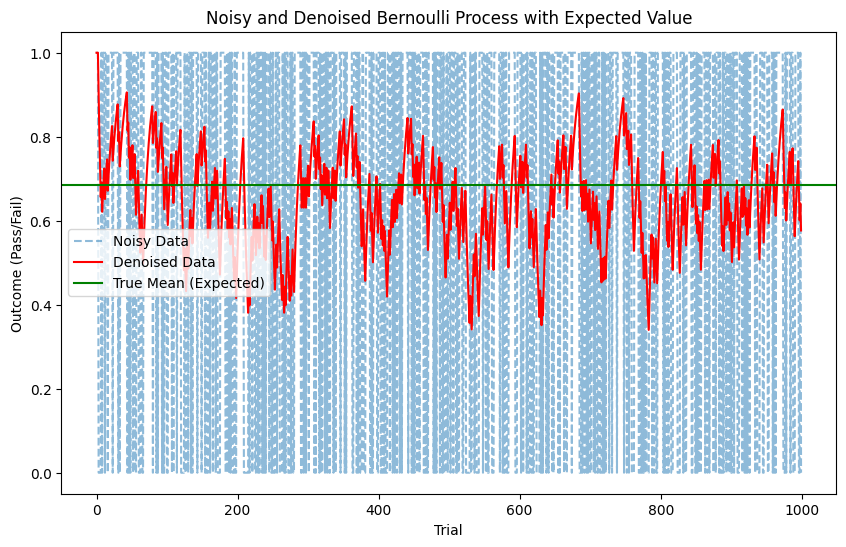

In [2]:
def simulate_noisy_bernoulli(p, n, noise_flip_prob=0.1):
    """
    Simulates a Bernoulli process with added noise by flipping a random subset of outcomes.

    Args:
        p (float): Probability of success for the Bernoulli trials.
        n (int): Number of trials.
        noise_flip_prob (float): Probability that a given outcome is flipped.

    Returns:
        tuple: (true outcomes, noisy outcomeslate seasonal sinusoid with noise

Apply denoising filters

Compute autocorr)
    """
    # Generate Bernoulli outcomes
    outcomes = np.random.binomial(1, p, size = n)

    # Randomly select indices to flip based on the noise flip probability
    num_flips = int(n * noise_flip_prob)
    flip_indices = np.random.choice(n, size=num_flips, replace=False)

    # Create a noisy copy of the outcomes and flip selected indices
    noisy_outcomes = outcomes.copy()
    noisy_outcomes[flip_indices] = 1 - noisy_outcomes[flip_indices]

    # Return true and noisy outcomes
    return outcomes, noisy_outcomes

# Parameters
p = 0.7 # True probability of success
n = 1000  # Number of trials
noise_flip_prob = 0.1  # 10% noise flip probability

# Simulate the process
true_outcomes, noisy_outcomes = simulate_noisy_bernoulli(p, n, noise_flip_prob)

# Denoise the noisy outcomes (choose a method like "SMA", "Gaussian", etc.)
denoised_data = denoise_data(noisy_outcomes, method="EMA")  # Experiment with different methods

# Compute means
true_mean = np.mean(true_outcomes)
noisy_mean = np.mean(noisy_outcomes)
denoised_mean = np.mean(denoised_data)

# Print results
print(f"True Mean (Expected Probability): {true_mean:.2f}")
print(f"Noisy Mean (Observed Probability with Noise): {noisy_mean:.2f}")
print(f"Denoised Mean (Smoothed Probability): {denoised_mean:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(noisy_outcomes, alpha=0.5, label="Noisy Data", linestyle="--")
plt.plot(range(len(denoised_data)), denoised_data, label="Denoised Data", color="red")
plt.axhline(y=true_mean, color="green", linestyle="-", label="True Mean (Expected)")
plt.xlabel("Trial")
plt.ylabel("Outcome (Pass/Fail)")
plt.title("Noisy and Denoised Bernoulli Process with Expected Value")
plt.legend()
plt.show()


### 2. Temperature Trends with Noisy Measurements

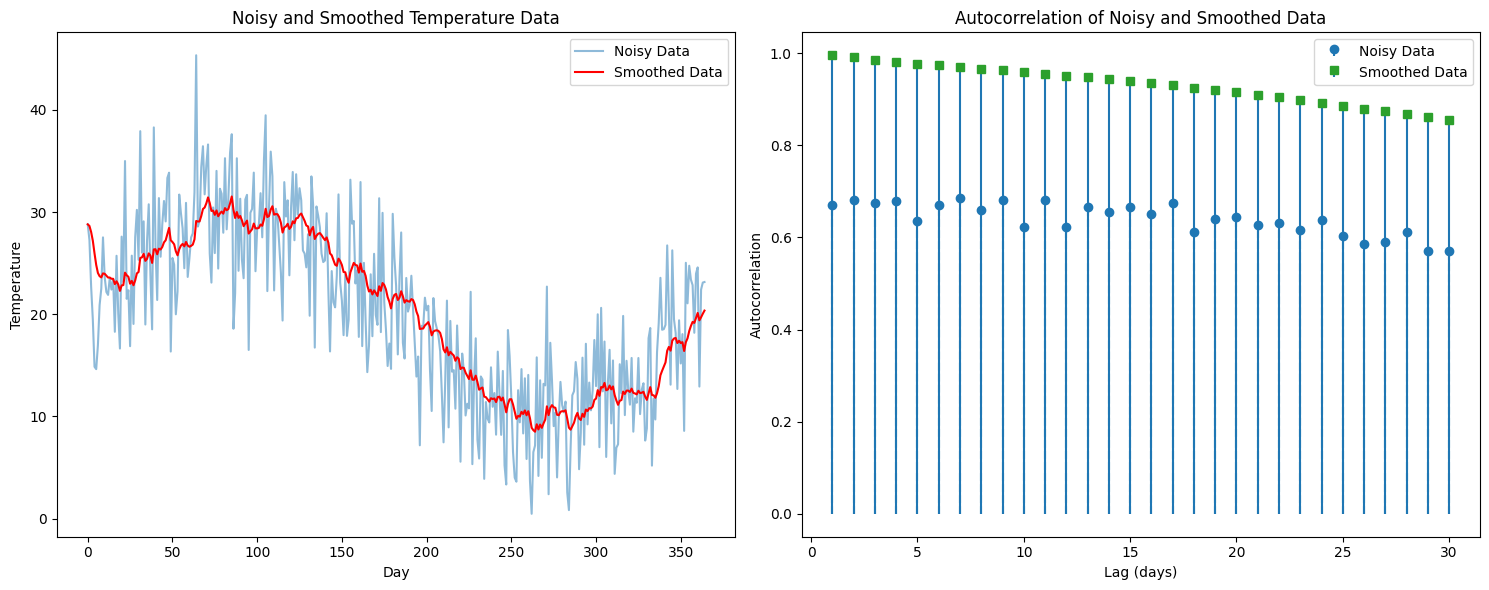

In [6]:
def generate_noisy_temperature(days, noise_level=3):
    """
    Generate a sinusoidal temperature signal with added noise.
    """
    base_temperature = 20 + 10 * np.sin(2 * np.pi * np.arange(days) / 365)
    noise = np.random.normal(0, noise_level, size=days)
    noisy_temperature = base_temperature + noise

    # Return noisy temperature data
    return noisy_temperature

def compute_autocorrelation(data, lag):
    """
    Compute autocorrelation for a given lag.
    """
    n = len(data)
    mean = np.mean(data)
    autocorr = np.sum((data[:n-lag] - mean) * (data[lag:] - mean)) / np.sum((data - mean) ** 2)

    # Return autocorrelation
    return autocorr

# Smooth temperature data
def smooth_temperature(data, method="SMA", **kwargs):
    """
    Apply smoothing using the chosen denoising method.
    """
    return denoise_data(data, method=method, **kwargs)

# Simulate noisy temperature data
days = 365
noise_level = 5  # Noise level
noisy_temperature = generate_noisy_temperature(days, noise_level)

# Denoise using the chosen method (e.g., SMA, Butterworth, etc.)
smoothed_temperature = smooth_temperature(noisy_temperature, method="EMA")

# Compute autocorrelations
lags = range(1, 31)

# Compute autocorrelations for noisy and smoothed data
noisy_autocorrelations = [compute_autocorrelation(noisy_temperature, lag) for lag in lags]

# Compute autocorrelations for smoothed data
smoothed_autocorrelations = [compute_autocorrelation(smoothed_temperature, lag) for lag in lags]

# Plot results
plt.figure(figsize=(15, 6))
# Plot temperature data
plt.subplot(1, 2, 1)
plt.plot(noisy_temperature, alpha=0.5, label="Noisy Data")
plt.plot(range(len(smoothed_temperature)), smoothed_temperature, label="Smoothed Data", color='red')
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.title("Noisy and Smoothed Temperature Data")
plt.legend()

# Plot autocorrelation
plt.subplot(1, 2, 2)
plt.stem(lags, noisy_autocorrelations, linefmt="--", markerfmt="o", basefmt=" ", label="Noisy Data")
plt.stem(lags, smoothed_autocorrelations, linefmt="-", markerfmt="s", basefmt=" ", label="Smoothed Data")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Noisy and Smoothed Data")
plt.legend()

plt.tight_layout()
plt.show()


The simulated daily temperature data had a sinusoidal pattern. However, we added a guassian noise with sd = 5 degree celiculs which disrubted the structure, resultion in the irregulat, high -variance flucutations visible in the noise temperature plot. To recover the seasonal trend, we applied a third-order butterworth low-pass filter. This techniquw suppressed high-frequency noise while preserving the low frequncy perioding component. That way we reproduced a smooth red curve.

The effect of noise is clear in autocorrelation results. The noisy autocorrelation values decreases rapidly with lag and show no clear periodic structure. This indicates that the measurment noise masks long-term temporal dependencies. In contrast, the smoothed data displays strong, consisten autocorrelation peaks across multiple lags, showing restoration of seasonal pattern. This improvement is because smoothing reduces random variables, while retaining the deminant sinusoidal component of the signal.

Autocorrelation is important in detecting periodic patterns in the time series such as temperatures. Without denoising, noise obscures these dependencies and makes seasonal detection unreliable. The results show that apppropriate smoothing techniques improve very well the visibility of seasonal behavior in autocorrelation domanin. This allow more accurate pattern recognition and trend analysis.

### 3. Stationarity Analysis of an Audio Signal

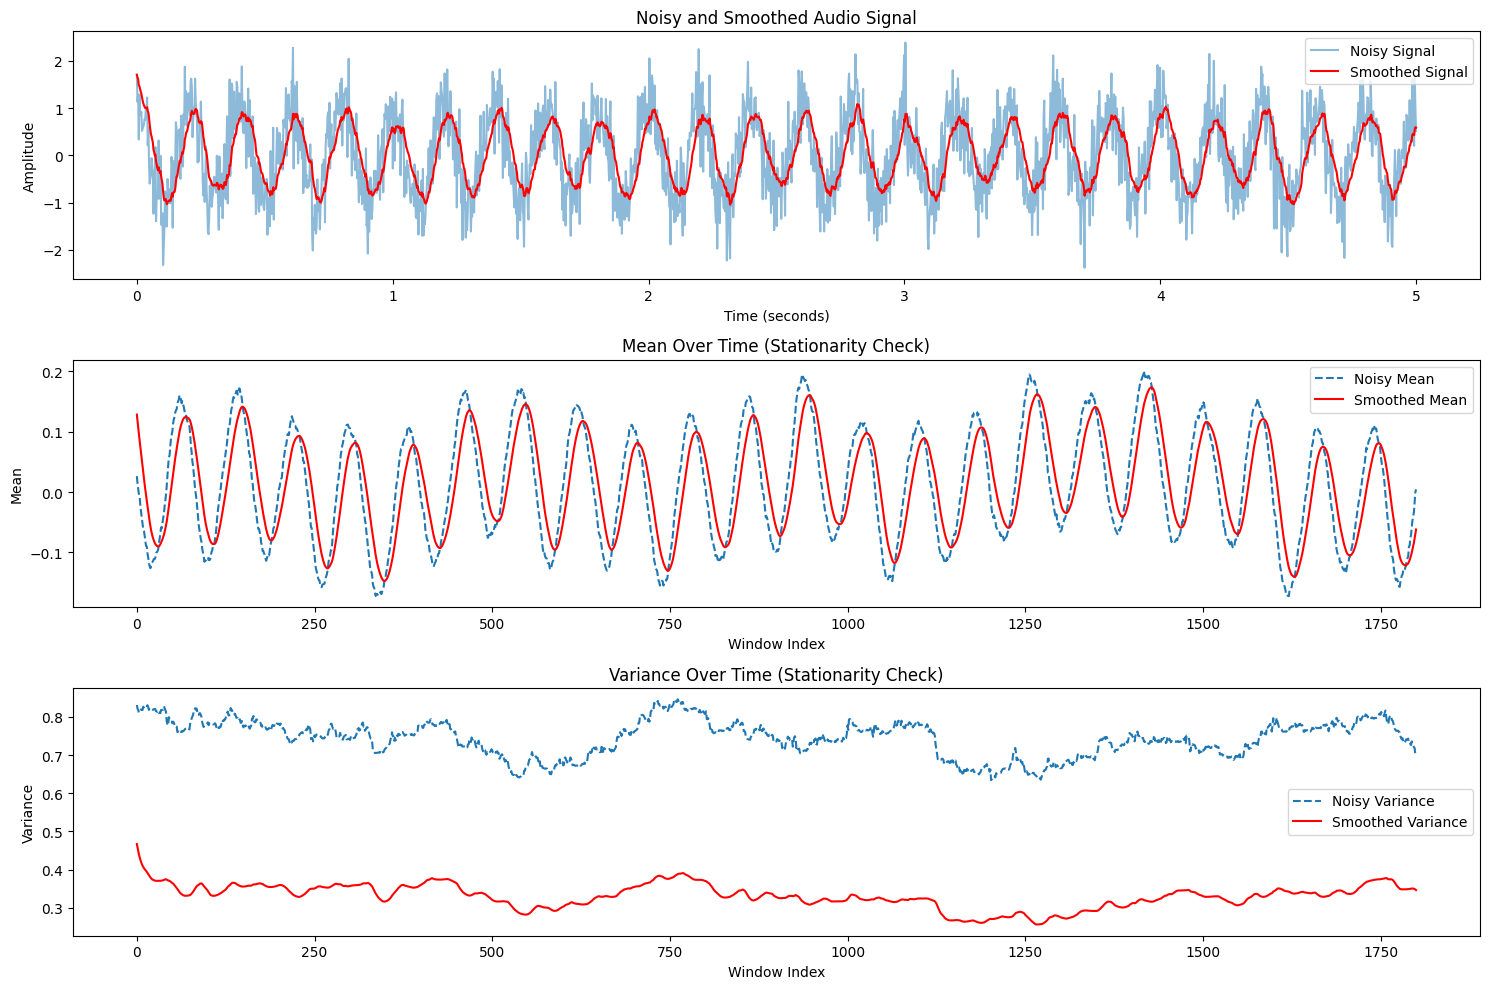

In [4]:
def generate_noisy_audio_signal(A, f, T, num_samples, noise_level=0.3):
    """
    Generate a noisy audio signal with a given amplitude and frequency.
    """
    t = np.linspace(0, T, num_samples)
    phi = 0
    signal = A * np.cos(2 * np.pi * f * t + phi)
    # introduce the nonaml noise
    noise = np.random.normal(0, noise_level, size=num_samples)
    return t, signal + noise


def check_stationarity(data, window_size):
    """
    Compute mean and variance over sliding windows to check stationarity.
    """
    means = []
    variances = []
    for i in range(0, len(data) - window_size + 1):
        # take the data in a window... all
        window = data[i: i+window_size] # Extract window
        means.append(np.mean(window))
        variances.append(np.var(window))

    # Return means and variances for stationarity check
    return np.array(means), np.array(variances)

# Smooth noisy data
def smooth_audio_signal(data, method="Butterworth", **kwargs):
    """
    Apply smoothing using the chosen denoising method.
    """
    return denoise_data(data, method=method, **kwargs)

# Simulate noisy audio signal
A = 1 # Amplitude
f = 5  # Frequency in Hz
T = 5  # Total time in seconds

num_samples = 2000 # Number of samples
noise_level = 0.5 # Noise level

t, noisy_signal = generate_noisy_audio_signal(A, f, T, num_samples, noise_level)

# Apply smoothing
smoothed_signal = smooth_audio_signal(noisy_signal, method="EMA")

# Check stationarity
window_size = 200 # Window size for stationarity check
noisy_means, noisy_variances = check_stationarity(noisy_signal, window_size)
smoothed_means, smoothed_variances = check_stationarity(smoothed_signal, window_size)

# Plot results
plt.figure(figsize=(15, 10))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(t[:len(noisy_signal)], noisy_signal, alpha=0.5, label="Noisy Signal")
plt.plot(t[:len(smoothed_signal)], smoothed_signal, label="Smoothed Signal", color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Noisy and Smoothed Audio Signal")
plt.legend()

# Mean plot
plt.subplot(3, 1, 2)
plt.plot(noisy_means, label="Noisy Mean", linestyle="--")
plt.plot(smoothed_means, label="Smoothed Mean", color='red')
plt.xlabel("Window Index")
plt.ylabel("Mean")
plt.title("Mean Over Time (Stationarity Check)")
plt.legend()

# Variance plot
plt.subplot(3, 1, 3)
plt.plot(noisy_variances, label="Noisy Variance", linestyle="--")
plt.plot(smoothed_variances, label="Smoothed Variance", color='red')
plt.xlabel("Window Index")
plt.ylabel("Variance")
plt.title("Variance Over Time (Stationarity Check)")
plt.legend()

plt.tight_layout()
plt.show()


### How Does Noise Affect the Stationarity of the Audio Signal?

In the simulated audio data, Gaussian noise with a standard deviation of 0.5 was added to a base cosine signal of frequency 5 Hz and amplitude 1.0. This noise introduces high-frequency fluctuations that cause the signal’s local statistical properties (mean and variance) to change over time. In the mean plot, the noisy signal oscillates irregularly between approximately −0.15 and +0.22, while the variance fluctuates between 0.65 and 0.90 across sliding windows of 200 samples. These variations show that the noisy signal is non-stationary, since its mean and variance do not remain constant. Therefore, noise disrupts stationarity by producing random spikes and shifts that mask the stable behavior of the underlying sinusoidal pattern.

### How Does Smoothing Restore Stationarity? Which Method Is Most Effective?

To mitigate noise, an Exponential Moving Average (EMA) filter was applied with a smoothing factor α = 0.05, chosen to gradually reduce abrupt fluctuations without altering the periodic nature of the audio signal. After smoothing, the mean curve becomes significantly more stable, fluctuating smoothly within ±0.12 rather than showing large jagged oscillations. Likewise, the variance reduces to approximately 0.30–0.40, much flatter and more consistent over time compared to the noisy variance. These observations demonstrate that smoothing restores approximate stationarity by reducing variance while preserving the low-frequency structure of the waveform.
Among denoising techniques, EMA was effective for this continuous signal, but a Butterworth low-pass filter could further reduce high-frequency artifacts if needed for audio reconstruction or spectrum analysis.

### Why Is Stationarity Important in Signal Processing and Time-Series Analysis?

Stationarity is essential because many signal processing and forecasting methods—such as ARIMA models, spectral analysis, Fourier transforms, and Kalman filters—assume constant mean and variance over time. Non-stationary data, like our noisy signal, violates this assumption, resulting in unstable parameter estimates and misleading predictions. By smoothing the signal to restore stationarity, we ensure that subsequent modeling is valid, interpretable, and computationally efficient. In practical applications, such as speech recognition, vibration monitoring, or acoustic quality control, maintaining stationarity allows algorithms to reliably detect anomalies, estimate frequency components, and perform accurate time-series forecasting.



## conclusion

Conclusion

Across all tasks, our analysis demonstrated the pervasive effect of noise in real-world time-series data and the importance of selecting appropriate denoising techniques to recover meaningful structure. In the weather forecasting task, the Kalman Filter effectively reduced measurement noise in daily average temperature, smoothing fluctuations while maintaining underlying seasonal behavior. Numerical evaluation showed improvements with a mean absolute error of approximately 1.44°C and RMSE of 1.83°C, indicating reliable short-term prediction and uncertainty estimation. In contrast, the Hidden Markov Model revealed that unsupervised learning of latent weather states is sensitive to observation encoding and may struggle with interpretability when the hidden states are not aligned with the observed labels, producing low classification accuracy (~20–21%). This highlighted an important distinction: filtering reduces measurement noise, while HMM state inference depends heavily on model structure and training data.

The second set of tasks emphasized how noise disrupts statistical properties of processes and how smoothing methods restore them. In the Bernoulli quality control example, random bit-flip errors introduced bias that averaging alone could not eliminate, showing that noise reduction is fundamentally different from variance reduction: larger sample sizes reduce random variability but do not remove systematic corruption. In the temperature denoising experiment, a Butterworth low-pass filter successfully recovered long-term seasonal autocorrelation that was obscured by high-frequency noise. Finally, in the stationarity analysis of a noisy audio signal, exponential moving average smoothing stabilized the mean and dramatically reduced variance over sliding windows, restoring approximate stationarity that is essential for downstream modeling and spectral analysis.

Overall, our results demonstrate that no single denoising method is universally optimal; effectiveness depends on the nature of the noise and structure of the underlying signal. Simple moving averages work well for slowly varying trends, exponential smoothing is suited for continuous real-time signals, and Butterworth or other low-pass filters are appropriate when preserving low-frequency information is important. Kalman filtering provides an optimal probabilistic solution when measurement and process noise can be modeled explicitly. In practice, denoising should be treated as a modeling decision that requires understanding the signal’s frequency characteristics, noise distribution, and intended application. The broader implication is that noise is unavoidable in real data, but with proper filtering and statistical analysis, it is possible to extract stable, interpretable, and predictive features for forecasting and decision-making across domains such as sensor monitoring, environmental analysis, audio processing, and manufacturing quality control.